1. Data Processing
2. EDA
3. Modeling (Attempts) - avoid overfitting
4. Evaluation 
5. Conclusions (Variable importance)

In [1]:
import pandas as pd
import numpy as np
import logging
from sklearn.preprocessing import OneHotEncoder
from datetime import datetime
from sklearn.preprocessing import StandardScaler , MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from seaborn import kdeplot

In [2]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()

In [3]:
train_df = pd.read_csv('./train.dsv',sep='|')
train_df.head()

,category,make_id,model_id,price__consumer_gross_euro,mileage,first_registration,condition,modification_time,features_central_locking,features_full_service_history,features_hu_au_neu,features_nonsmoker_vehicle,features_adaptive_cruise_ctl,features_abs
2,EstateCar,1900,9.0,16990.000000,94672.0,200602.0,USED,2011-04-06 00:39:09,True,False,False,False,False,True
3,EstateCar,1900,9.0,9749.990234,176675.0,200606.0,USED,2011-04-06 00:38:39,True,True,False,False,False,True
4,Limousine,1900,8.0,9960.299805,109230.0,200608.0,USED,2011-06-03 19:16:35,True,False,True,False,False,True
5,Limousine,1900,8.0,21899.570312,22275.0,201002.0,USED,2011-06-03 19:16:40,True,False,True,False,False,True
6,EstateCar,1900,9.0,7700.000000,244000.0,200408.0,USED,2011-06-03 19:22:40,True,True,False,False,False,True


## EDA

In [4]:
train_df.shape

(12876, 14)

In [5]:
train_df.dtypes

category                          object
make_id                            int64
model_id                         float64
price__consumer_gross_euro       float64
mileage                          float64
first_registration               float64
condition                         object
modification_time                 object
features_central_locking            bool
features_full_service_history       bool
features_hu_au_neu                  bool
features_nonsmoker_vehicle          bool
features_adaptive_cruise_ctl        bool
features_abs                        bool
dtype: object

In [6]:
for col in ['category','make_id','model_id','condition']:
    logger.info(f"col {col} has unique values : '{train_df[col].unique()}, \
        with count = {len(train_df[col].unique())}")

INFO:root:col category has unique values : '['EstateCar' 'Limousine' 'SportsCar' 'Cabrio' 'OffRoad' 'SmallCar'
 'OtherCar' 'Van'],         with count = 8
INFO:root:col make_id has unique values : '[ 1900 25100],         with count = 2
INFO:root:col model_id has unique values : '[ 9.  8. 10. 23. 32. 11.  1. 12. 31. 15. 16.  3. 33. 28. 27.  4. 13. 29.
 19. 20. 30.  2.  5. 22. 21.  7. 14. 24.  6. 25. 34. 37. 39. 36. 17. 35.
 40. 26. 41. 38. 42. 18. nan],         with count = 43
INFO:root:col condition has unique values : '['USED' 'NEW'],         with count = 2


In [7]:
idx = np.isnan(train_df['first_registration'])
train_df.loc[idx,].head()

,category,make_id,model_id,price__consumer_gross_euro,mileage,first_registration,condition,modification_time,features_central_locking,features_full_service_history,features_hu_au_neu,features_nonsmoker_vehicle,features_adaptive_cruise_ctl,features_abs
50,EstateCar,1900,8.0,19999.000000,0.0,NaN,NEW,2009-10-05 13:58:47,True,False,False,False,False,True
53,SportsCar,1900,31.0,29290.750000,0.0,NaN,NEW,2009-10-05 13:58:37,True,False,False,False,False,True
114,Cabrio,1900,9.0,33888.820312,0.0,NaN,NEW,2009-10-28 13:15:57,True,False,False,False,False,True
115,Limousine,1900,11.0,55889.539062,0.0,NaN,NEW,2009-10-28 13:15:57,True,False,False,False,False,True
117,Limousine,1900,8.0,20448.960938,0.0,NaN,NEW,2009-10-28 13:15:58,True,False,False,False,False,True


### Price EDA

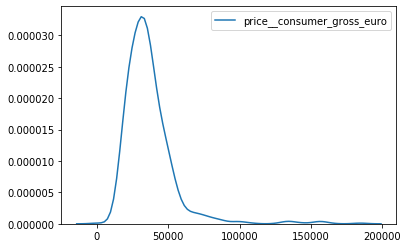

In [8]:
## assumption 1 , new vs used, is a signifcant two sub data sets
price_new =train_df.loc[train_df.condition=='NEW','price__consumer_gross_euro']
kdeplot(price_new)

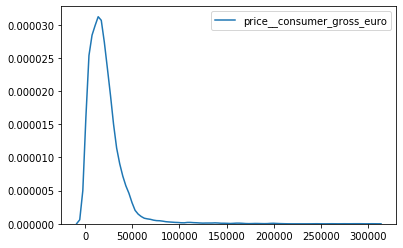

In [9]:
price_used =train_df.loc[train_df.condition=='USED','price__consumer_gross_euro']
kdeplot(price_used)

It is clear we have close distributions between used and new, however we have long tails that are considered outliers
start with main stream, remove outliers

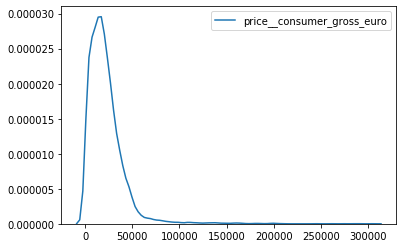

In [10]:
price= train_df['price__consumer_gross_euro']
kdeplot(price)

In [11]:
price.describe()

count     12876.000000
mean      21847.646792
std       20034.312170
min           1.000000
25%        9737.492676
50%       17983.495117
75%       28499.000000
max      304761.000000
Name: price__consumer_gross_euro, dtype: float64

In [12]:
q = np.quantile(price,q=[0.01,0.95])
q

array([  786.75, 49900.  ])

In [13]:
# count of outliers
idx = (q[0] <= price) & (price<=q[1])
idx.value_counts()

True     12115
False      761
Name: price__consumer_gross_euro, dtype: int64

In [14]:
idx.value_counts()[0]/len(idx)

0.05910220565392979

In [15]:
# Data Understanding 
# what is modification time ?

## Data Preprocessing

In [16]:
# parse first registration yyyy-mm.0
# s = str(int(200602.0))
# datetime.strptime(s,'%Y%m')
def preprocess(train_df):
    #drop na
    na_idx = train_df.isnull().any(1)
    train_df = train_df.loc[~na_idx,]
    train_df['first_registration_date'] = pd.to_datetime(train_df['first_registration'].\
                apply(lambda x: np.datetime64('NaT') if np.isnan(x) else datetime.strptime(str(int(x)),'%Y%m')))
    train_df['modification_time'] = pd.to_datetime(train_df['modification_time'])
    for col in train_df.columns:
        if train_df[col].dtype==bool:
            train_df[col] = train_df[col].astype(int)
    # remove outliers
    price= train_df['price__consumer_gross_euro']
    q = np.quantile(price,q=[0.01,0.95])
    idx = (q[0] <= price) & (price<=q[1])
    train_df = train_df.loc[idx,]
    # focus only on used cars , experimented and didn't work
    # idx = train_df.condition == 'USED'     
    return train_df

In [17]:
train_df_pp = preprocess(train_df)
train_df_pp.head()

/home/mbaddar/mbaddar/ds/ebay_interview/car_price_pred_env/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/mbaddar/mbaddar/ds/ebay_interview/car_price_pred_env/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/home/mbaddar/mbaddar/ds/ebay_interview/car_price_pred_env/lib/python3.7/site-packages/ipykernel_launcher.py:13: Setti

,category,make_id,model_id,price__consumer_gross_euro,mileage,first_registration,condition,modification_time,features_central_locking,features_full_service_history,features_hu_au_neu,features_nonsmoker_vehicle,features_adaptive_cruise_ctl,features_abs,first_registration_date
2,EstateCar,1900,9.0,16990.000000,94672.0,200602.0,USED,2011-04-06 00:39:09,1,0,0,0,0,1,2006-02-01
3,EstateCar,1900,9.0,9749.990234,176675.0,200606.0,USED,2011-04-06 00:38:39,1,1,0,0,0,1,2006-06-01
4,Limousine,1900,8.0,9960.299805,109230.0,200608.0,USED,2011-06-03 19:16:35,1,0,1,0,0,1,2006-08-01
5,Limousine,1900,8.0,21899.570312,22275.0,201002.0,USED,2011-06-03 19:16:40,1,0,1,0,0,1,2010-02-01
6,EstateCar,1900,9.0,7700.000000,244000.0,200408.0,USED,2011-06-03 19:22:40,1,1,0,0,0,1,2004-08-01


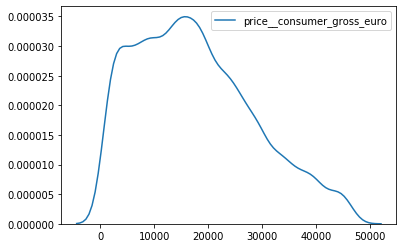

In [18]:
# plot price after outlier removal
kdeplot(train_df_pp['price__consumer_gross_euro'])

## Feature Generation

In [19]:
train_df_pp.dtypes

category                                 object
make_id                                   int64
model_id                                float64
price__consumer_gross_euro              float64
mileage                                 float64
first_registration                      float64
condition                                object
modification_time                datetime64[ns]
features_central_locking                  int64
features_full_service_history             int64
features_hu_au_neu                        int64
features_nonsmoker_vehicle                int64
features_adaptive_cruise_ctl              int64
features_abs                              int64
first_registration_date          datetime64[ns]
dtype: object

In [20]:
def to_datetime(date):
    """
    Converts a numpy datetime64 object to a python datetime object 
    Input:
      date - a np.datetime64 object
    Output:
      DATE - a python datetime object
    """
    timestamp = ((date - np.datetime64('1970-01-01T00:00:00'))
                 / np.timedelta64(1, 's'))
    return datetime.utcfromtimestamp(timestamp)

In [21]:
def gen_features(data_in):
    data_in['months_since_first_registration'] = data_in['first_registration_date']\
                    .apply(lambda x:np.NaN if pd.isna(x) else (datetime.today()-x).days/30)
    # train_df['months_since_modification_time'] = train_df['modification_time']\
    #                  .apply(lambda x:np.NaN if pd.isna(x) else (datetime.today()-x).days/30)
    categories_cols = ['category','make_id','model_id','condition']
    #enc = OneHotEncoder(categories=categories)
    data_dummy = pd.get_dummies(data=data_in,columns=categories_cols,prefix=categories_cols,drop_first=True)
    #  train_df_dummy.drop(columns=categories,axis=1)
    # delete unneded cols 
    data_dummy.drop(columns=['first_registration','first_registration_date','modification_time'],inplace=True)
    return data_dummy

In [22]:
train_df_features = gen_features(train_df_pp)
train_df_features.head()

,price__consumer_gross_euro,mileage,features_central_locking,features_full_service_history,features_hu_au_neu,features_nonsmoker_vehicle,features_adaptive_cruise_ctl,features_abs,months_since_first_registration,category_EstateCar,...,model_id_32.0,model_id_33.0,model_id_34.0,model_id_35.0,model_id_36.0,model_id_37.0,model_id_38.0,model_id_39.0,model_id_40.0,model_id_41.0
2,16990.000000,94672.0,1,0,0,0,0,1,169.866667,1,...,0,0,0,0,0,0,0,0,0,0
3,9749.990234,176675.0,1,1,0,0,0,1,165.866667,1,...,0,0,0,0,0,0,0,0,0,0
4,9960.299805,109230.0,1,0,1,0,0,1,163.833333,0,...,0,0,0,0,0,0,0,0,0,0
5,21899.570312,22275.0,1,0,1,0,0,1,121.166667,0,...,0,0,0,0,0,0,0,0,0,0
6,7700.000000,244000.0,1,1,0,0,0,1,188.166667,1,...,0,0,0,0,0,0,0,0,0,0


## Modeling
### To attempt:
1. NN
2. Baseline , regression model

### Model (1) MLP:

In [23]:
train_df_features.head()

,price__consumer_gross_euro,mileage,features_central_locking,features_full_service_history,features_hu_au_neu,features_nonsmoker_vehicle,features_adaptive_cruise_ctl,features_abs,months_since_first_registration,category_EstateCar,...,model_id_32.0,model_id_33.0,model_id_34.0,model_id_35.0,model_id_36.0,model_id_37.0,model_id_38.0,model_id_39.0,model_id_40.0,model_id_41.0
2,16990.000000,94672.0,1,0,0,0,0,1,169.866667,1,...,0,0,0,0,0,0,0,0,0,0
3,9749.990234,176675.0,1,1,0,0,0,1,165.866667,1,...,0,0,0,0,0,0,0,0,0,0
4,9960.299805,109230.0,1,0,1,0,0,1,163.833333,0,...,0,0,0,0,0,0,0,0,0,0
5,21899.570312,22275.0,1,0,1,0,0,1,121.166667,0,...,0,0,0,0,0,0,0,0,0,0
6,7700.000000,244000.0,1,1,0,0,0,1,188.166667,1,...,0,0,0,0,0,0,0,0,0,0


### Features, Scaling / Normalizing
https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02

In [24]:
def scale_normalize_features(data_in):    
    # TODO experiment other scalars based on better EDA for cols distributions
    #months_since_modification_time
    features_to_scale = ['mileage','months_since_first_registration']
    scaler = MinMaxScaler().fit(data_in[features_to_scale])
    mtx_scaled_features = pd.DataFrame(data=scaler.transform(data_in[features_to_scale])\
                                       ,columns=[f +'_scaled' for f in features_to_scale])
    mtx_scaled_features['join_key'] = list(np.arange(mtx_scaled_features.shape[0]))
#     print('mtx_scaled_feat')
#     print(mtx_scaled_features.head())
    data_in_dropped = data_in.drop(columns = features_to_scale)
    data_in_dropped['join_key'] = list(np.arange(mtx_scaled_features.shape[0]))
#     print('data_in_dropped')
#     print(data_in_dropped.head())
    #data_in_scaled = pd.concat([data_in_dropped,mtx_scaled_features],axis=1,ignore_index=True)
    data_in_scaled = pd.merge(left=data_in_dropped,right=mtx_scaled_features,on='join_key')
    data_in_scaled.drop(columns='join_key',inplace=True)
    return data_in_scaled

In [25]:
train_df_features_scaled = scale_normalize_features(train_df_features)
train_df_features_scaled.head()

,price__consumer_gross_euro,features_central_locking,features_full_service_history,features_hu_au_neu,features_nonsmoker_vehicle,features_adaptive_cruise_ctl,features_abs,category_EstateCar,category_Limousine,category_OffRoad,...,model_id_34.0,model_id_35.0,model_id_36.0,model_id_37.0,model_id_38.0,model_id_39.0,model_id_40.0,model_id_41.0,mileage_scaled,months_since_first_registration_scaled
0,16990.000000,1,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0.039121,0.149023
1,9749.990234,1,1,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0.073006,0.143478
2,9960.299805,1,0,1,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0.045136,0.140659
3,21899.570312,1,0,1,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0.009205,0.081512
4,7700.000000,1,1,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0.100826,0.174391


In [26]:
#https://scikit-learn.org/stable/auto_examples/plot_partial_dependence_visualization_api.html#sphx-glr-auto-examples-plot-partial-dependence-visualization-api-py

In [27]:
y_colname = 'price__consumer_gross_euro'
y = train_df_features_scaled[y_colname]
X = train_df_features_scaled.drop(columns=y_colname)
X.columns

Index(['features_central_locking', 'features_full_service_history',
       'features_hu_au_neu', 'features_nonsmoker_vehicle',
       'features_adaptive_cruise_ctl', 'features_abs', 'category_EstateCar',
       'category_Limousine', 'category_OffRoad', 'category_OtherCar',
       'category_SmallCar', 'category_SportsCar', 'category_Van',
       'make_id_25100', 'model_id_2.0', 'model_id_3.0', 'model_id_4.0',
       'model_id_5.0', 'model_id_6.0', 'model_id_7.0', 'model_id_8.0',
       'model_id_9.0', 'model_id_10.0', 'model_id_11.0', 'model_id_12.0',
       'model_id_13.0', 'model_id_14.0', 'model_id_15.0', 'model_id_16.0',
       'model_id_17.0', 'model_id_18.0', 'model_id_19.0', 'model_id_20.0',
       'model_id_21.0', 'model_id_22.0', 'model_id_23.0', 'model_id_24.0',
       'model_id_25.0', 'model_id_26.0', 'model_id_27.0', 'model_id_28.0',
       'model_id_29.0', 'model_id_30.0', 'model_id_31.0', 'model_id_32.0',
       'model_id_33.0', 'model_id_34.0', 'model_id_35.0', 'model_id_

In [28]:
X.shape

(10777, 56)

In [29]:
y.shape

(10777,)

In [30]:
# Drop any row having NA, think of better imputing approach
x_na_idx = X.isnull().any(1)
X_non_na = X.loc[~x_na_idx,]
y_non_na = y.loc[~x_na_idx,]

In [31]:
# mlp = MLPRegressor(hidden_layer_sizes=(1000),tol=1e-2, max_iter=10000, random_state=0,verbose=False\
#                    ,learning_rate_init=5,learning_rate='adaptive')
# mlp_fit = mlp.fit(X_non_na,y_non_na)
# mlp_fit

### use Grid_cv_search

In [33]:
param_grid = {'activation':['identitiy','logistic','tanh', 'relu'],\
             'hidden_layer_sizes':[(40,),(60,),(80,),(100,),(50,50),(100,100)],\
             'learning_rate_init':[1,10],\
             'tol' : [0.001],\
             'alpha':list(10.0 ** -np.arange(1, 2))}
mlp = MLPRegressor()
grid_search_cv_fit = GridSearchCV(estimator=mlp,param_grid=param_grid,verbose=True\
                                  ,scoring='neg_root_mean_squared_error'\
                                  ,n_jobs=4)\
                .fit(X_non_na,y_non_na)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  88 tasks      | elapsed:   40.0s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  4.3min finished


In [34]:
grid_search_cv_fit.best_estimator_

MLPRegressor(activation='relu', alpha=0.1, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100,), learning_rate='constant',
             learning_rate_init=1, max_fun=15000, max_iter=200, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=None, shuffle=True, solver='adam', tol=0.001,
             validation_fraction=0.1, verbose=False, warm_start=False)

In [35]:
neg_rmse = grid_search_cv_fit.best_score_

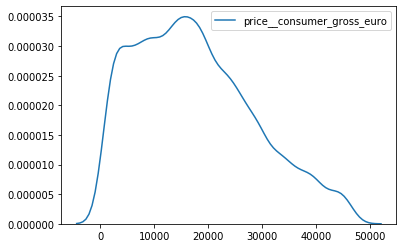

In [36]:
kdeplot(y_non_na)

In [37]:
q = np.quantile(y_non_na,q=[0.05,0.95])
nrmsd = -neg_rmse/(q[1]-q[0])
nrmsd

0.13288308569147955

## Grid CV results summary

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.

[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:  3.1min finished

In [38]:
# cross validation
# over under estimating prices
# https://scikit-learn.org/stable/modules/neural_networks_supervised.html#tips-on-practical-use
# https://machinelearningmastery.com/how-to-configure-the-number-of-layers-and-nodes-in-a-neural-network/
#https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

## Apply on Test Data

In [39]:
test_df = pd.read_csv('./test.dsv',sep='|')
test_df.head()

,category,make_id,model_id,price__consumer_gross_euro,mileage,first_registration,condition,modification_time,features_central_locking,features_full_service_history,features_hu_au_neu,features_nonsmoker_vehicle,features_adaptive_cruise_ctl,features_abs
1,EstateCar,1900,9.0,11349.990234,175461.0,200801.0,USED,2011-04-06 00:38:39,True,True,False,False,False,True
9,EstateCar,1900,10.0,9380.000000,105000.0,200201.0,USED,2011-06-03 19:23:27,True,True,False,False,False,True
17,EstateCar,1900,9.0,18900.000000,68050.0,200512.0,USED,2009-10-26 13:02:07,True,False,False,False,False,True
25,EstateCar,1900,9.0,10591.000000,152408.0,200506.0,USED,2009-10-28 13:08:27,True,True,False,False,False,True
33,EstateCar,1900,9.0,27469.960938,6790.0,200902.0,USED,2009-10-14 13:47:07,True,True,False,False,False,True


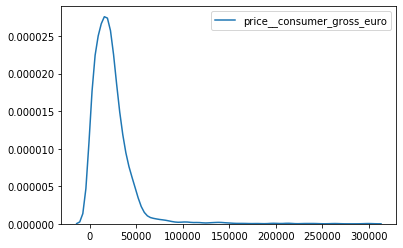

In [40]:
kdeplot(test_df['price__consumer_gross_euro'])

In [41]:
test_df_pp = preprocess(test_df)
test_df_pp.columns

/home/mbaddar/mbaddar/ds/ebay_interview/car_price_pred_env/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/mbaddar/mbaddar/ds/ebay_interview/car_price_pred_env/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/home/mbaddar/mbaddar/ds/ebay_interview/car_price_pred_env/lib/python3.7/site-packages/ipykernel_launcher.py:13: Setti

Index(['category', 'make_id', 'model_id', 'price__consumer_gross_euro',
       'mileage', 'first_registration', 'condition', 'modification_time',
       'features_central_locking', 'features_full_service_history',
       'features_hu_au_neu', 'features_nonsmoker_vehicle',
       'features_adaptive_cruise_ctl', 'features_abs',
       'first_registration_date'],
      dtype='object')

In [42]:
N_train = train_df_pp.shape[0]
aug_df = train_df_pp.append(test_df_pp,ignore_index=True)

/home/mbaddar/mbaddar/ds/ebay_interview/car_price_pred_env/lib/python3.7/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [43]:
aug_df_pp_features = gen_features(aug_df)
test_df_pp_features = aug_df_pp_features[(N_train+1):]
test_df_pp_features.shape

(2092, 57)

In [44]:
train_df_features.shape

(10777, 57)

In [45]:
test_df_pp_feat_scale = scale_normalize_features(test_df_pp_features)
test_df_pp_feat_scale.head(100)

,features_abs,features_adaptive_cruise_ctl,features_central_locking,features_full_service_history,features_hu_au_neu,features_nonsmoker_vehicle,price__consumer_gross_euro,category_EstateCar,category_Limousine,category_OffRoad,...,model_id_34.0,model_id_35.0,model_id_36.0,model_id_37.0,model_id_38.0,model_id_39.0,model_id_40.0,model_id_41.0,mileage_scaled,months_since_first_registration_scaled
0,1,0,1,1,0,0,9380.000000,1,0,0,...,0,0,0,0,0,0,0,0,0.110287,0.262948
1,1,0,1,0,0,0,18900.000000,1,0,0,...,0,0,0,0,0,0,0,0,0.071477,0.188958
2,1,0,1,1,0,0,10591.000000,1,0,0,...,0,0,0,0,0,0,0,0,0.160082,0.198427
3,1,0,1,1,0,0,27469.960938,1,0,0,...,0,0,0,0,0,0,0,0,0.007132,0.129042
4,1,0,1,1,0,0,7650.000000,0,1,0,...,0,0,0,0,0,0,0,0,0.216825,0.333885
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1,0,1,0,1,0,2300.000000,0,1,0,...,0,0,0,0,0,0,0,0,0.193265,0.338542
96,1,0,1,0,0,0,12000.000000,1,0,0,...,0,0,0,0,0,0,0,0,0.018906,0.144875
97,1,0,1,0,0,0,6500.000000,1,0,0,...,0,0,0,0,0,0,0,0,0.073420,0.207844
98,0,0,1,1,0,0,10490.000000,0,1,0,...,0,0,0,0,0,0,0,0,0.049682,0.215760


In [46]:
y_test = test_df_pp_feat_scale[y_colname]
X_test = test_df_pp_feat_scale.drop(columns=[y_colname])

In [47]:
X_test.shape

(2092, 56)

In [48]:
y_predicted = grid_search_cv_fit.best_estimator_.predict(X_test)

In [49]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_true=y_test,y_pred=y_predicted))
rmse/(max(y_test)-min(y_test))

0.1641335099205275

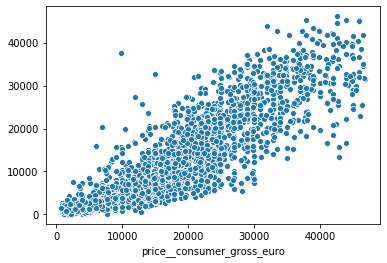

In [50]:
from seaborn import scatterplot
scatterplot(x=y_test,y=y_predicted)

In [51]:
def smape(A, F):
    return 100/len(A) * np.sum(np.abs(F - A) / (np.abs(A) + np.abs(F)))
smape(A=y_test,F=y_predicted)

26.620489073106267

In [52]:
# TODO next, handle outlier prices, find common feature and create a different model